    (ordered) position is deprecated.  Please use at()  (deprecated in 6.1,
    will be removed in (or after) 7.0) (called from
    C:\Users\mattm\AppData\Local\Temp\ipykernel_28136\1513299124.py:178)
Total cost: 6.62
Model unknown

  Variables:
    PV_curt : Size=48, Index=TS
        Key : Lower : Value                  : Upper : Fixed : Stale : Domain
          1 :     0 : 2.1732330203367222e-09 :  None : False : False : NonNegativeReals
          2 :     0 : 2.1732330150564363e-09 :  None : False : False : NonNegativeReals
          3 :     0 :  2.173232952344979e-09 :  None : False : False : NonNegativeReals
          4 :     0 : 2.1732329278041068e-09 :  None : False : False : NonNegativeReals
          5 :     0 :  2.173232907875569e-09 :  None : False : False : NonNegativeReals
          6 :     0 :  2.173232877203172e-09 :  None : False : False : NonNegativeReals
          7 :     0 :  2.173232868500246e-09 :  None : False : False : NonNegativeReals
          8 :     0 :  2.173

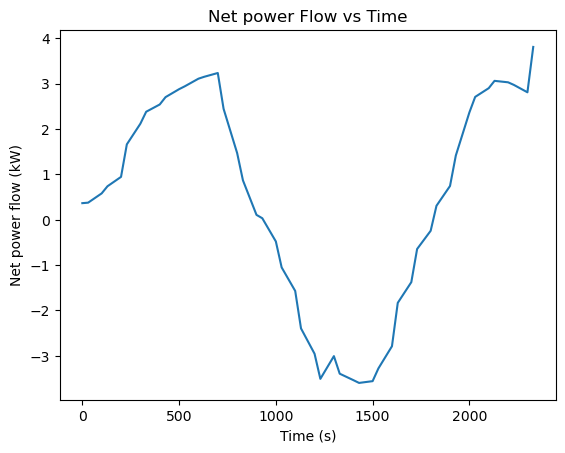

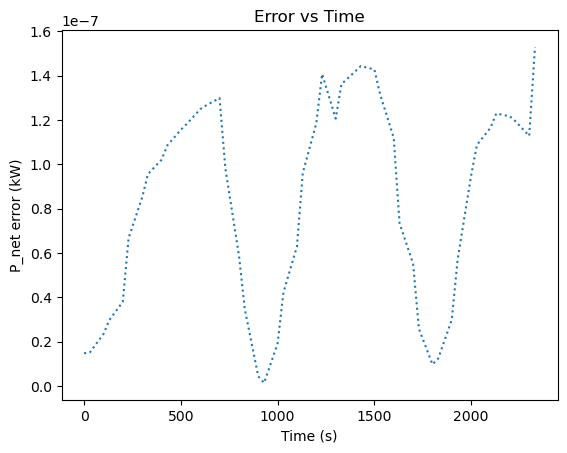

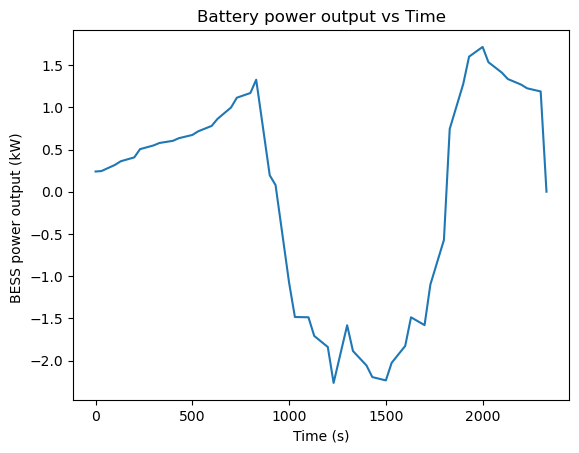

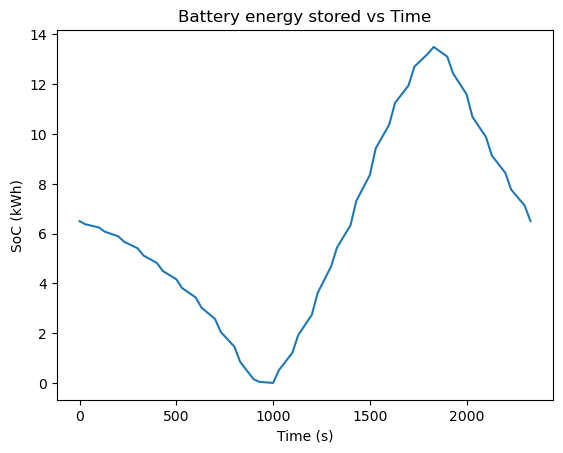

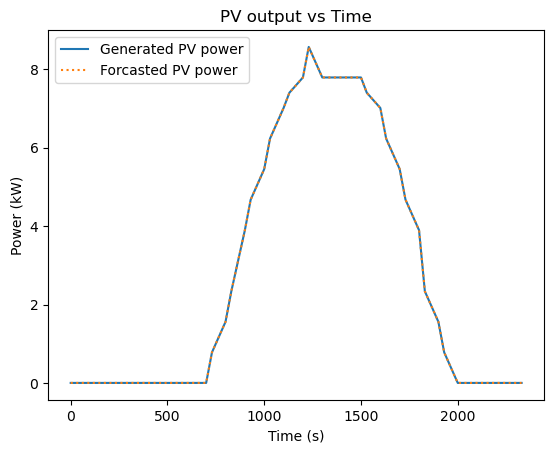

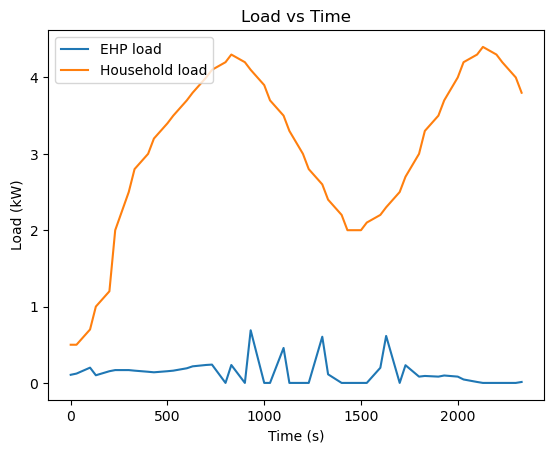

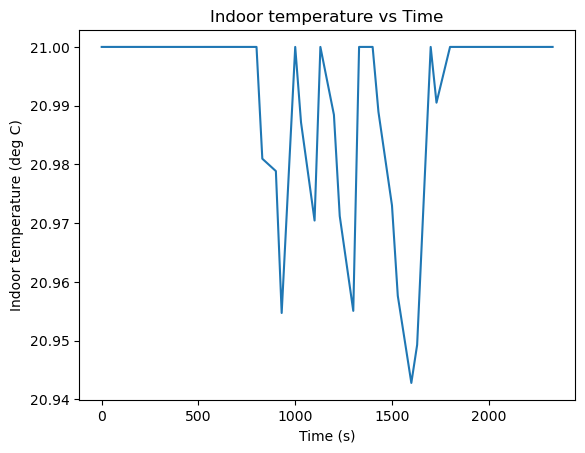

In [1]:
# Import required packages #
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
import numpy as np
from pyomo.core.base import (ConcreteModel,Set,Var,Objective,Constraint,
                             Param, NonNegativeReals,PositiveReals, Reals)
import os
import pandas as pd
import json
from pyomo.environ import *
import random
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Funcion for generating randomized occupancy vector
def generate_occupancy_signal(time_array):
    # 24 hours of data plus one extra time step
    signal_length = 49
    
    # Generate a signal of 0s intially
    signal = [0] * signal_length

    # Assume home between 6 PM and 8 AM 
    for i,time in enumerate(time_array):
        if time <= 800 or time >=  1800:
            signal[i] = 1
        
    # Set final time step value based on previous value
    signal[-1] = signal[-2]

    # Randomly set other values to 1 or 0
    for i in range(signal_length):
        if signal[i] == 0 and random.random() < 0.2:
            signal[i] = 1

    return signal

# Function for updating occupancy vector for next time step
def update_occupancy(Occupancy, time_array_new):
    del Occupancy[0]  # Delete the first element

    # Gennerate new time point data (Assume home between 6 PM and 8 AM, other points random)
    if (time_array_new[-1] <= 800 or time_array_new[-1] >=  1800) or random.random() < 0.2:
        new_val = 1
    else:
        new_val = 0
        
    Occupancy.append(new_val)
    return Occupancy

# Optimizer controller     
class controller:

    # Inital building temperature and SOC (should be fed back as input after first execution)
    inital_temp = 21
    inital_SoC = 6.5 # 50 percent
    period_end =  48 # End point of time period relative to the inital loop run
    
    def controller_model(self,T_out, Load, Ins_PV, Im_tariff, Ex_tariff, Occupancy):
        
        ### PYOMO MODEL ###
        
        # Create the model object:
        m = ConcreteModel()

        # Indices for each timestep, here i= 1 to 48
        m.TS = Set(initialize=[i+1 for i in range(48)])

        # Time step between data in hours (30 minutes = 0.5 hours)
        m.dt = 0.5 

        # Load usage data as model parameter
        m.P_Load =  Param(m.TS,initialize={i: Load[i-1] for i in m.TS}) # Set as parameter of model

        # Tariff (assuming same price for export and import and constant)
        m.import_tariff = Param(m.TS, initialize= Im_tariff) # $ per kwh
        m.export_tariff = Param(m.TS, initialize= Ex_tariff) # $ per kwh

        ### INPUTS ###

        # The SoC should always return to 50 percent at the same time in every time horizon
        target_SoC = 6.5

        # Power flow error tolerance (increase to avoid infeasabilities)
        error_tolerance = 0.001 # kW
        
        # Number of occupants
        occupants = 2

        # Minimum and maximum temperature of the house (comfort constraint)
        temp_min = 18 # Degrees
        temp_max = 24 # Degrees
        temp_pref = 21 # Degrees

        # Angle of panels
        panel_angle = 30  # Inclination in deg

        # Area of panels
        Area = 50 # m2

        # Panel efficency 
        eta_PV = 0.18 # 18% defined as PV_max (kW)/[Area (m2)*1 (kW/m2)]

        # Heat pump max output
        EHP_heat_max = 3 # kWth 

        # Battery max charge/discharge rate in kw
        BESS_max = 5 

        # Battery minimum SOC 
        SoC_min = 0

        # Battery maximum SOC 
        SoC_max = 13.5 # kWh

        # Battery charging efficency
        eta_ch = 0.95 

        # Battery discharging efficiency
        eta_dis = 0.95 

        # Battery self-consumption losses (typically very small values, assumed here to be zero for simplicity)
        BESS_losses = 0 

        # Building thermal capacitance which reflects its thermal inertia and therefore its ability to absorb, store and release heat
        Cb = 23.16 # kWh/K 

        # Building material thermal resistance which reflects its ability to resist heat flow
        Rb= 8.38 # K/kW 

        # Absorbed solar radiation which depends on the building structure
        SHGC = 0 # For buildings with double glazed windows, typical valuesfor the Solar Heat Gain Coefficient (SHGC) are in the range of 0.42 - 0.55. However, in this example we assume it to be zero.

        # Heat gain per occupant
        heat_gains = 0.12 # kW/occupant

        # Export limit in kW
        export_lim = 5

        ### PV MODEL ###

        # Parameters
        # Calculate the cosine of the panel inclination angle
        cosine_angle = math.cos(math.radians(panel_angle))
        m.PV_f=Param(m.TS,initialize={i: eta_PV*Area*Ins_PV[i-1] * cosine_angle for i in m.TS}) # PV forecasted power output: eta_PV*Ins_PV(t)*Area 

        # Decision variables
        m.PV_curt = Var(m.TS,initialize=0,domain=NonNegativeReals)  # PV curtailment resulting from the optimization model
        
        ### EHP MODEL ###

        # Parameters
        COP_T = 0.25* T_out + 1 # COP(T_out) as a linear function of the outdoor temperature with slope=4
        m.COP = Param(m.TS,initialize={i: COP_T[i-1] for i in m.TS}) # Store COP vector as time series parameter

        # Decision variables
        m.ehp_E_input = Var(m.TS,initialize=0,domain=NonNegativeReals) # EHP electrical power input (kW) 

        ### BESS MODEL ###

        # Bounds definitions for variables
        # Discharge cannot be greater than limit
        def BESS_ch_dis_rule(model,i):
            return (0,BESS_max)
        # SOC cannot be less than minimum value and more than maximum value
        def SoC_rule(model,i):
            return (SoC_min,SoC_max)

        # Decision variables
        m.BESS_ch = Var(m.TS,initialize=0,bounds=BESS_ch_dis_rule) # Battery charging (consuming) power
        m.BESS_dis = Var(m.TS,initialize=0,bounds=BESS_ch_dis_rule) # Battery discharging (generating) power 
        m.SoC = Var(m.TS,initialize=self.inital_SoC,bounds=SoC_rule) # Battery SOC

        # Constraints
        def BESS_rule(model,i):
            if i==1: # SoC at the start of the time horizon is equal to the SoC at the end
                i0=model.TS[-1]
            else:
                i0=i-1
            return model.SoC[i]-model.SoC[i0] - ((eta_ch*model.BESS_ch[i0])-(model.BESS_dis[i0]/eta_dis)-BESS_losses)*model.dt == 0
        


        ### BUILDING MODEL ###

        # Parameters
        m.TS_aux = Set(initialize=[i+1 for i in range(49)]) # Auxiliary time 
        m.Temp_Out = Param(m.TS, initialize={i: T_out[i-1] for i in m.TS}) # Prediction of outdoor temperature 
        m.Sol = Param(m.TS, initialize={i: SHGC*Ins_PV[i-1] for i in m.TS}) # The kWh solar gain, that is the heat increase of a structure resulting from solar radiation 
        Int_Heat_Gains_Data = heat_gains*occupants # Heat gain due to occupants 
        Int = [i*Int_Heat_Gains_Data for i in Occupancy] # Heat gain at each time step
        m.Int = Param(m.TS, initialize={i: Int[i-1] for i in m.TS}) # Heat coming from the presence of occupants in the building (metabolic gain)
        m.Occ = Param(m.TS_aux, initialize={i: Occupancy[i-1] for i in m.TS_aux})
        
        # Variables
        m.temp = Var(m.TS_aux, initialize=self.inital_temp, bounds=(temp_min,temp_max)) # Inside temperature of the building
        m.alpha = Var(m.TS_aux,initialize=0,bounds=(0,1)) # Alpha (ventilation variable)

        # Constraints
        
        ### POWER FLOW MODEL ###

        # Variables
        m.P_in = Var(m.TS,initialize=0,domain=NonNegativeReals) # Power flowing in is positive
        m.P_out = Var(m.TS,initialize=0,bounds=(-export_lim,0)) # Power flowing out is negative and bounded by export limit
        m.error =  Var(m.TS,initialize=0,bounds=(-error_tolerance,error_tolerance))

        # Constraints
        # Power cannot be flowing in and out at the same time. So either P_in or P_out should be equal to 0 at every time point.
        def Direction(model,i):
            return model.P_in[i]*model.P_out[i]+m.error[i] == 0
        
        # Net power flowing in or out is equal to the difference between the load and generation of the house. The net flow is either equal to the flow in (P_in) or the flow out (P_out). If net power is positive P_out should be 0 and if net power is negative P_in should be negative.
        def Power_flow(model,i):
            return model.P_in[i] + model.P_out[i] - (model.P_Load[i]+model.ehp_E_input[i] - (m.BESS_dis[i]-m.BESS_ch[i]) -(model.PV_f[i] - model.PV_curt[i]))== 0
        

        # Equality constraitnts for all models
        # Net power flow
        m.lambda1 = Constraint(m.TS,rule=Power_flow)
        # Power in and out rule
        m.lambda2 = Constraint(m.TS,rule=Direction)
        # Charging rule
        m.lambda3 = Constraint(m.TS, rule=BESS_rule)
        # Temperature evolution depends on the heat transfers and building characteristics.
        # The heat energy from the pump is equal to the output heat power of the pump multiplied by the time step length (joins heat pump and building model)
        m.lambda4 = Constraint(m.TS, rule=lambda m, i: m.temp[i+1] - (m.temp[i]+((m.ehp_E_input[i]*m.COP[i]) + (1-m.alpha[i])*(m.Int[i]+m.Sol[i])-(m.temp[i]-m.Temp_Out[i])*(1/Rb))*m.dt*(1/Cb))== 0)
        # Set inital SOC to given inital value
        m.lambda5 = Constraint(rule=lambda m: m.SoC[1] - self.inital_SoC== 0)
        # Set at starting time point SOC to inital value 
        m.lambda6 = Constraint(rule=lambda m: m.SoC[self.period_end]-target_SoC == 0)
        # Set inital temperature to inital value input (cant be controlled)
        m.lambda7 = Constraint(rule=lambda m: m.temp[1]- self.inital_temp == 0)
             
        # Inequalities for all models
        m.mu1 = Constraint(m.TS, rule=lambda m, i: m.P_in[i] >= 0)
        m.mu2 = Constraint(m.TS, rule=lambda m, i: -m.P_out[i] >= 0)
        m.mu3 = Constraint(m.TS, rule=lambda m, i: m.P_out[i] + export_lim >= 0)
        m.mu4 = Constraint(m.TS, rule=lambda m, i: -(m.PV_curt[i] - m.PV_f[i]) >= 0)
        m.mu5 = Constraint(m.TS, rule=lambda m, i: m.PV_curt[i] >= 0)
        m.mu6 = Constraint(m.TS, rule=lambda m, i: (EHP_heat_max - (m.ehp_E_input[i] * m.COP[i])) >= 0)
        m.mu7 = Constraint(m.TS, rule=lambda m, i: m.ehp_E_input[i] * m.COP[i] >= 0)
        m.mu8 = Constraint(m.TS, rule=lambda m, i: BESS_max - m.BESS_ch[i] >= 0)
        m.mu9 = Constraint(m.TS, rule=lambda m, i: m.BESS_ch[i] >= 0)
        m.mu10 = Constraint(m.TS, rule=lambda m, i: BESS_max - m.BESS_dis[i] >= 0)
        m.mu11 = Constraint(m.TS, rule=lambda m, i: m.BESS_dis[i] >= 0)
        m.mu12 = Constraint(m.TS, rule=lambda m, i: SoC_max - m.SoC[i] >= 0)
        m.mu13 = Constraint(m.TS, rule=lambda m, i: m.SoC[i] - SoC_min >= 0)
        m.mu14 = Constraint(m.TS_aux, rule=lambda m, i: temp_max - m.temp[i] >= 0)
        m.mu15 = Constraint(m.TS_aux, rule=lambda m, i: m.temp[i] - temp_min >= 0)
        m.mu16 = Constraint(m.TS_aux, rule=lambda m, i: m.temp[i] - (temp_pref - 100*(1-m.Occ[i])) >= 0)
        m.mu17 = Constraint(m.TS, rule=lambda m, i: temp_pref + 100*(1-m.Occ[i]) - m.temp[i] >= 0)

        ### OBJECTIVE FUNCTION ###

        # Define the objective function (minimize the total cost), where the cost is equal to the energy (net power flow multiplied by the time step) multiplied by the tariff for each direction
        m.objective = pyo.Objective(expr=sum((m.import_tariff[i]*m.P_in[i] + m.export_tariff[i]*m.P_out[i])*m.dt  for i in m.TS),sense=minimize)

        # Create a 'dual' suffix component on the instance
        # so the solver plugin will know which suffixes to collect
        m.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

        ### USE MODEL ###
        solver = pyo.SolverFactory('ipopt')
        results = solver.solve(m)
        
        ### RESULTS  ###
        print(f"Total cost: {pyo.value(m.objective):.2f}")
        # Uncomment this line to see results printed out
        m.display()
        
        ### Code for plotting dual\lagrange values

        # Create lists to store the constraint names and dual values for each category
        # constraint_names_l = []
        # dual_values_l = []
        # constraint_names_m = []
        # dual_values_m = []

        # # Iterate over constraints and store dual values in the appropriate lists
        # for c in m.component_objects(pyo.Constraint, active=True):
        #     constraint_name = str(c)
        #     dual_value_list = []

        #     for index in c:
        #         dual_value_list.append(m.dual[c[index]])

        #     if len(dual_value_list) == 1:
        #         print(constraint_name + ": " + str(dual_value_list[0]))
        #     elif constraint_name.startswith('l'):
        #         constraint_names_l.append(constraint_name)
        #         dual_values_l.append(dual_value_list)
        #     elif constraint_name.startswith('m'):
        #         constraint_names_m.append(constraint_name)
        #         dual_values_m.append(dual_value_list)

        # # Plot dual values for constraints with labels starting with "l"
        # if len(constraint_names_l) > 0:
        #     plt.figure()
        #     for i in range(len(constraint_names_l)):
        #         plt.plot(range(1, len(dual_values_l[i]) + 1), dual_values_l[i], label='$\lambda_{'+str(i+1)+'}$')
        #     plt.xlabel('Time Step')
        #     plt.ylabel('Dual Value')
        #     plt.title('Dual Values for equality constraints')
        #     plt.legend(loc='upper right', framealpha=0.7)
        #     plt.show()

        # # Plot dual values for constraints with labels starting with "m"
        # if len(constraint_names_m) > 0:
        #     num_plots = len(constraint_names_m) // 10 + 1  # Number of subplots needed
        #     for i in range(num_plots):
        #         start_idx = i * 10
        #         end_idx = (i + 1) * 10
        #         constraints = constraint_names_m[start_idx:end_idx]
        #         dual_values = dual_values_m[start_idx:end_idx]

        #         plt.figure()
        #         for j in range(len(constraints)):
        #             constraint_label = '$\mu_{'+str(j+start_idx+1)+'}$'
        #             plt.plot(range(1, len(dual_values[j]) + 1), dual_values[j], label=constraint_label)
        #         plt.xlabel('Time Step')
        #         plt.ylabel('Dual Value')
        #         plt.title('Dual Values for inequality constraints')
        #         plt.legend(loc='upper right', framealpha=0.7)
        #         plt.show()


        ### SET INITAL VALUES FOR NEXT EXECUTION ###
        self.inital_temp = value(m.temp[1])
        self.inital_SoC = value(m.SoC[1])
        if self.period_end == 1:
            self.period_end = 48
        else: 
            self.period_end = self.period_end-1


        return m
    

def plot_forecast(m, time_values):
    # Extract values
    BESS_net_values = [pyo.value(m.BESS_dis[i])-pyo.value(m.BESS_ch[i]) for i in m.TS]  
    SoC_values = [pyo.value(m.SoC[i]) for i in m.TS]
    PV_values = [pyo.value(m.PV_f[i]) - pyo.value(m.PV_curt[i]) for i in m.TS] 
    PV_f_values = [pyo.value(m.PV_f[i]) for i in m.TS]
    P_net_values = [pyo.value(m.P_in[i])+pyo.value(m.P_out[i]) for i in m.TS]
    error_values = [pyo.value(m.error[i]) for i in m.TS]
    EHP_values = [pyo.value(m.ehp_E_input[i]) for i in m.TS]
    temp_values = [pyo.value(m.temp[i]) for i in m.TS]

    # Plot P_in vs time
    plt.plot(time_values, P_net_values)
    plt.xlabel('Time (s)')
    plt.ylabel('Net power flow (kW)')
    plt.title('Net power Flow vs Time')
    plt.show()

    # Plot error vs time
    plt.plot(time_values, error_values, linestyle='dotted')
    plt.xlabel('Time (s)')
    plt.ylabel('P_net error (kW)')
    plt.title('Error vs Time')
    plt.show()

    # Plot BESS_net vs time
    plt.plot(time_values, BESS_net_values)
    plt.xlabel('Time (s)')
    plt.ylabel('BESS power output (kW) ')
    plt.title('Battery power output vs Time')
    plt.show()

    # Plot SoC vs time
    plt.plot(time_values, SoC_values)
    plt.xlabel('Time (s)')
    plt.ylabel('SoC (kWh)')
    plt.title('Battery energy stored vs Time')
    plt.show()

    # Plot PV vs time
    plt.plot(time_values, PV_values, label='Generated PV power')
    plt.plot(time_values, PV_f_values, linestyle='dotted', label='Forcasted PV power')
    plt.xlabel('Time (s)')
    plt.ylabel('Power (kW)')
    plt.title('PV output vs Time')
    plt.legend()
    plt.show()

    # Load vs time
    plt.plot(time_values, EHP_values, label='EHP load')
    plt.plot(time_values, Load, label='Household load')
    plt.xlabel('Time (s)')
    plt.ylabel('Load (kW)')
    plt.title('Load vs Time')
    plt.legend()
    plt.show()

    # Indoor temp vs time
    plt.plot(time_values, temp_values)
    plt.xlabel('Time (s)')
    plt.ylabel('Indoor temperature (deg C)')
    plt.title('Indoor temperature vs Time')
    plt.show()

    return

# Generate initial data for 24 hours 
################################################ DUMMY DATA TO BE REPLACED WITH ML ################################################

# Outside temperature data
#http://www.bom.gov.au/products/IDV60901/IDV60901.95936.shtml#other_formats
mydir = os.getcwd()
loc = mydir + '/temp.json'
f = open(loc)
data = json.load(f)
weather = data['observations']['data'] #This gives all kind of information as a dict at every time point
temp = [] # Temperature array
for t in weather[0:48]: #can choose how many data point here up to 72.
    temp.append(t['air_temp']) 
T_out = np.array(temp) # Numpy array of outside temps and convert to kW

Load = [0.5, 0.5, 0.7, 1.0, 1.2, 2.0, 2.5, 2.8, 3.0, 3.2, 3.4, 3.5, 3.7, 3.8, 4.0, 4.1, 4.2, 4.3, 4.2, 4.1, 3.9, 3.7, 3.5, 3.3, 3.0, 2.8, 2.6, 2.4, 2.2, 2.0, 2.0, 2.1, 2.2, 2.3, 2.5, 2.7, 3.0, 3.3, 3.5, 3.7, 4.0, 4.2, 4.3, 4.4, 4.3, 4.2, 4.0, 3.8]

# Insolation (kW/m2) data
Ins_PV = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1.0, 1.1, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95, 0.9, 0.8, 0.7, 0.6, 0.5 ,0.3, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  
# Time array (24 hours)
time_array = [i // 2 * 100 + (i % 2) * 30 for i in range(48)]

############################################################################################################################

# Tarriffs 
Im_tariff = 0.25 
Ex_tariff = 0.05

# Generate occupancy array
Occupancy = generate_occupancy_signal(time_array)


# Specify simulation length 
sim_length = 48

# Arrays for storing results
time = np.zeros(sim_length)
BESS_net = np.zeros(sim_length)
SoC = np.zeros(sim_length)
PV = np.zeros(sim_length)
PV_f = np.zeros(sim_length)
P_net = np.zeros(sim_length)
EHP =  np.zeros(sim_length)
temp_in = np.zeros(sim_length)

# Run optimization model
c=controller()
m = c.controller_model(T_out, Load, Ins_PV, Im_tariff, Ex_tariff, Occupancy)

# Store intital values 
time[1] = time_array[1]
BESS_net[1] = value(m.BESS_dis[1]) - value(m.BESS_ch[1])
SoC[1] = value(m.SoC[1])
PV[1] = value(m.PV_f[1])-value(m.PV_curt[1])
PV_f[1] = value(m.PV_f[1])
P_net[1] = value(m.P_in[1])+value(m.P_out[1])
EHP[1] = value(m.ehp_E_input[1])
temp_in[1] = value(m.temp[1])

# Plot forecast (optional function for checking the otpimizer schedule)
plot_forecast(m,time_array)  


# Update Occcupancy array based on new time array
Occupancy = update_occupancy(Occupancy, time_array)
